# **Importing libraries**

In [1]:
!pip install yfinance

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import os, datetime
# os.environ['TF_CPP_LOG_LEVEL'] = '1'
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
# warnings.filterwarnings('ignore')

import yfinance as yf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 580 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# **Load data**

In [5]:
df = yf.download("GOOG", start = "2000-01-01")

[*********************100%***********************]  1 of 1 completed


In [6]:
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.sort_values('Date', inplace = True)
df.drop('Adj Close', inplace=True, axis=1)

# **Preprocessing**

In [7]:
''' Calculating percentage changes w.r.t previous day '''
df['Open'] = df['Open'].pct_change()
df['High'] = df['High'].pct_change()
df['Low'] = df['Low'].pct_change()
df['Close'] = df['Close'].pct_change()
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True)

In [10]:
def normalize(df):
  mins = df[['Open','High','Low','Close','Volume']].min(axis=0)
  maxs = df[['Open','High','Low','Close','Volume']].max(axis=0)
  df['Open'] = (df['Open'] - mins['Open'])/(maxs['Open']-mins['Open'])
  df['High'] = (df['High'] - mins['High'])/(maxs['High']-mins['High'])
  df['Low'] = (df['Low'] - mins['Low'])/(maxs['Low']-mins['Low'])
  df['Close'] = (df['Close'] - mins['Close'])/(maxs['Close']-mins['Close'])
  df['Volume'] = (df['Volume'] - mins['Volume'])/(maxs['Volume']-mins['Volume'])
  return mins, maxs

mins, maxs = normalize(df)

# **Data Split**

In [11]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]

df_train = df[(df.index < last_20pct)] # 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]


train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (3680, 5)
Validation data shape: (460, 5)
Test data shape: (459, 5)


# **Hyperparameters**

In [12]:
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

# **Train, Val and Test Data Preparation**

In [13]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (3552, 128, 5) (3552,)
Validation set shape (332, 128, 5) (332,)
Testing set shape (331, 128, 5) (331,)


# **TimeVector Layer**

In [14]:
class Time2Vector(tf.keras.layers.Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    # print(self.seq_len)
    self.weights_linear = self.add_weight(name = 'weight_linear',
                                          shape = ([int(self.seq_len)]),
                                          initializer = 'uniform',
                                          trainable = True)
    
    self.phi_linear = self.add_weight(name = 'phi_linear',
                                       shape = ([int(self.seq_len)]),
                                       initializer = 'uniform',
                                       trainable = True)
    
    self.weights_periodic = self.add_weight(name = 'weight_periodic',
                                            shape = ([int(self.seq_len)]),
                                            initializer = 'uniform',
                                            trainable = True)
    
    self.phi_periodic = self.add_weight(name = 'phi_periodic',
                                            shape = ([int(self.seq_len)]),
                                            initializer = 'uniform',
                                            trainable = True)
    
  def call(self, x):
    # print(x)
    # print(x.shape)
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    # print("Shapes:", self.weights_linear.shape, x.shape, self.phi_linear.shape)
    time_linear = self.weights_linear * x + self.phi_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    # print("Time Linear shape:", time_linear.shape)
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.phi_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)

    return tf.concat([time_linear, time_periodic], axis = -1) # shape = (batch, seq_len, 2)

  def get_config(self):
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

# **Transformer**

In [15]:
class SingleAttention(tf.keras.layers.Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = tf.keras.layers.Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = tf.keras.layers.Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = tf.keras.layers.Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(tf.keras.layers.Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = tf.keras.layers.Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    # print(attn)
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.attn_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = tf.keras.layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = tf.keras.layers.Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.ff_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    # print(inputs)
    # print("1")
    attn_layer = self.attn_multi(inputs)
    # print("2")
    attn_layer = self.attn_dropout(attn_layer)
    # print("3")
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)
    # print("4")

    ff_layer = self.ff_conv1D_1(attn_layer)
    # print("5")
    ff_layer = self.ff_conv1D_2(ff_layer)
    # print("6")
    ff_layer = self.ff_dropout(ff_layer)
    # print("7")
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    # print("8")
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config  

# **Training**

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  # print(in_seq)
  x = time_embedding(in_seq)
  # print((tf.reshape(x,(-1,x.shape[0],x.shape[1]))).shape)
  # x = Concatenate(axis=-1)([in_seq, tf.reshape(x, (-1,x.shape[0],x.shape[1]))])
  x = Concatenate(axis=-1)([in_seq, x])
  # x = tf.keras.backend.placeholder_with_default(x, [None, x.shape[0], x.shape[1]])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer1+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)
# print(X_val.shape, y_val.shape)
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=20, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('/content/Transformer1+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 5)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 128, 2)       512         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 7)       0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 128, 7)      99114       ['concatenate[0][0]',        

11/11 [==============================] - 2s 194ms/step
 
Evaluation metrics
Training Data - Loss: 0.0034, MAE: 0.0389
Validation Data - Loss: 0.0048, MAE: 0.0463
Test Data - Loss: 0.0048, MAE: 0.0511


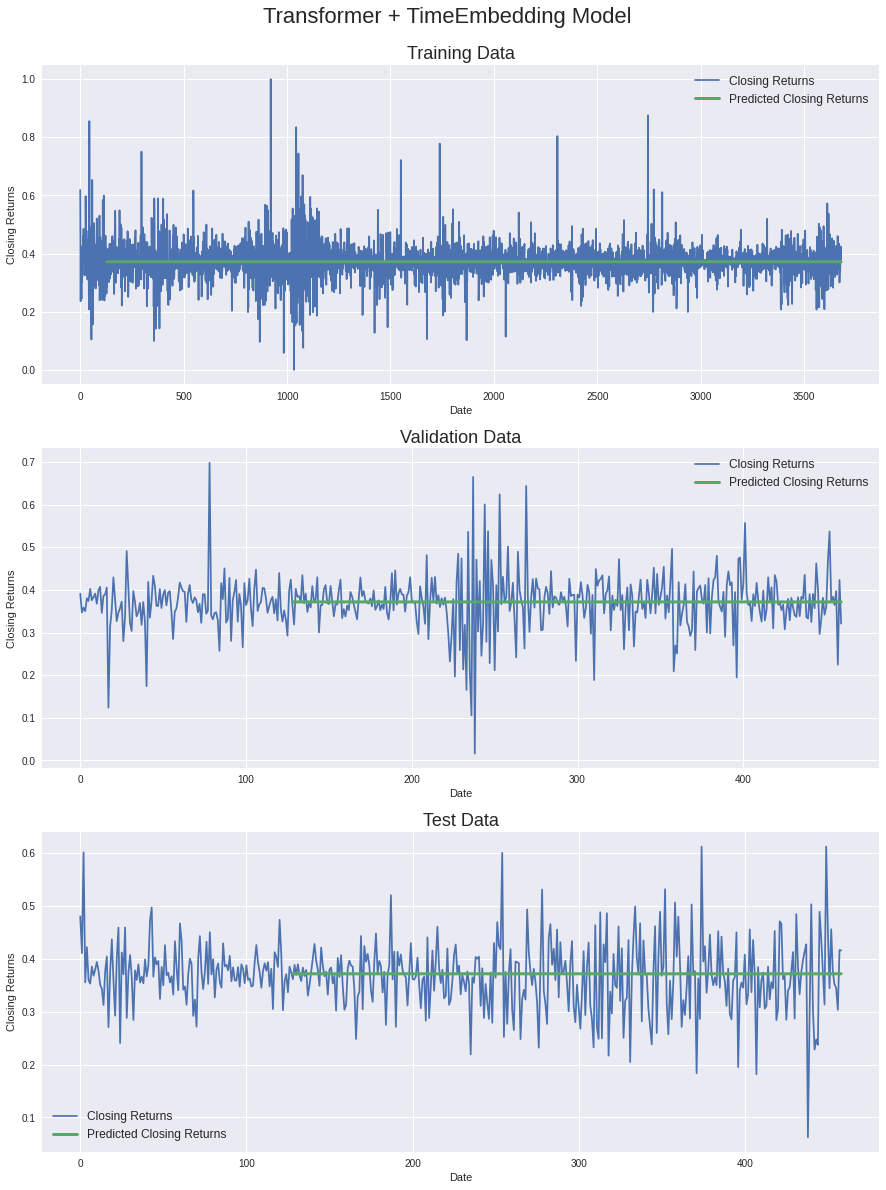

In [ ]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_eval[0], val_eval[1]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}'.format(test_eval[0], test_eval[1]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)

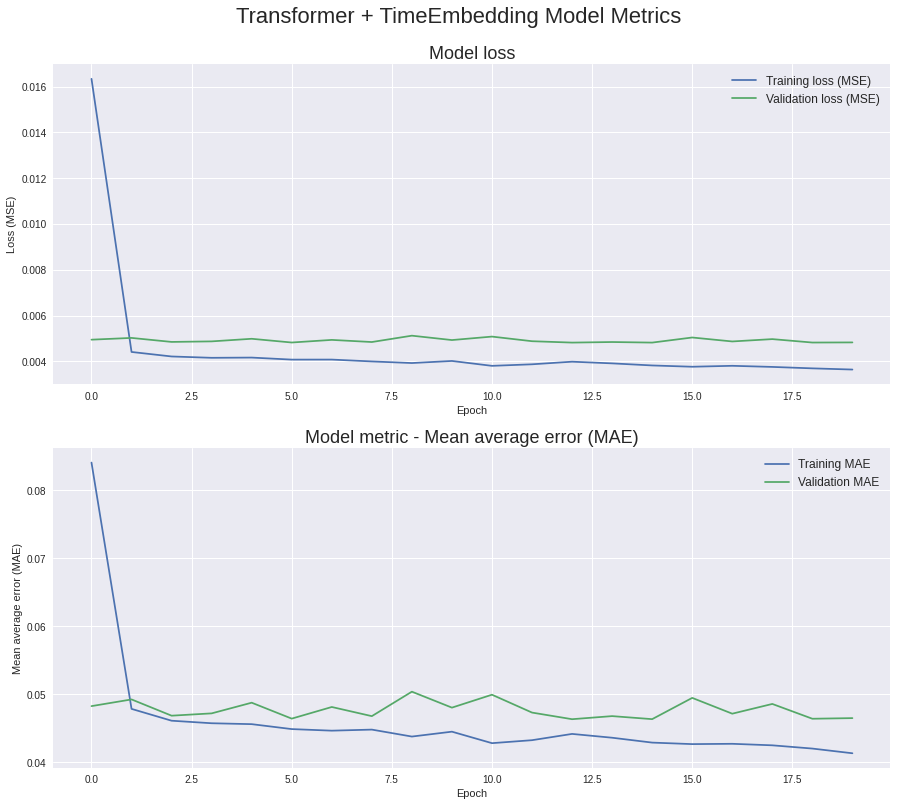

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

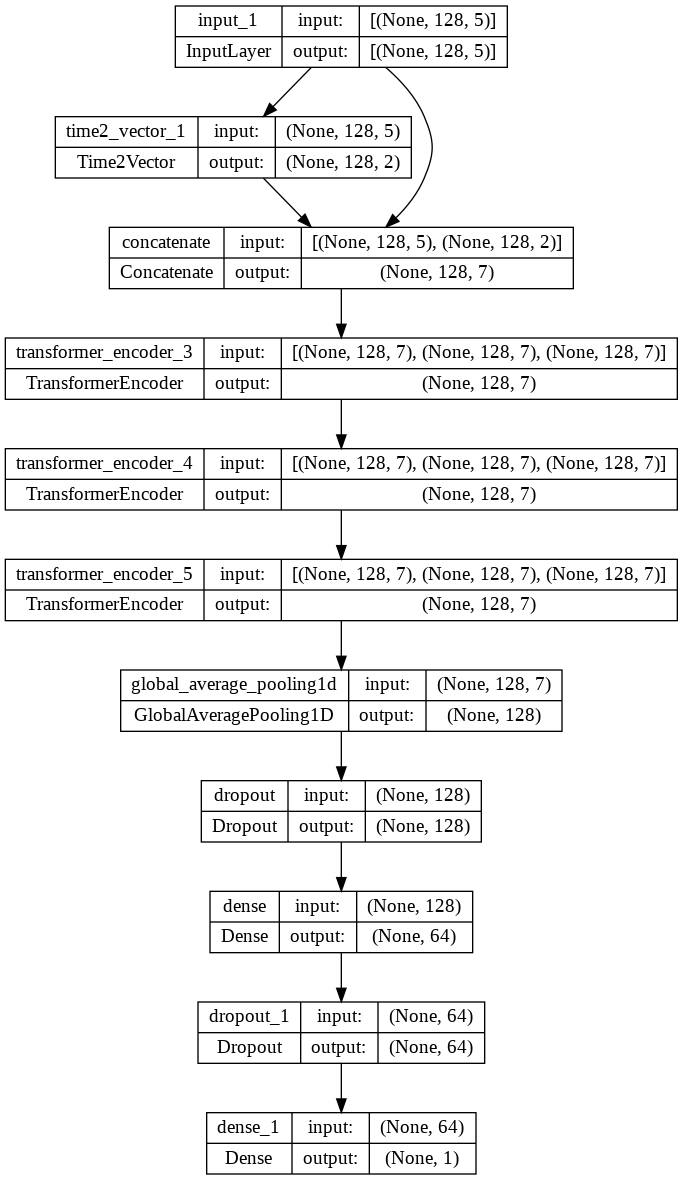

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)